In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.ticker import MultipleLocator, MaxNLocator
import seaborn as sns
from ast import literal_eval
from pathlib import Path
from itertools import product
from joblib import Parallel, delayed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.ticker import MaxNLocator

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (14, 3.5)

In [51]:
dataset_names = {42900: "Breast Cancer Coimbra",
                 41945: "Indian Liver Patients",
                 "thorax": "Coronary Heart Disease"}

In [52]:
# load all files
df = pd.concat((pd.read_csv(f) for f in Path("../results").glob("*.csv") if f.stat().st_size > 0 ), ignore_index=True)
df = df.drop("params",axis=1)
df["test_brier"] = -df["test_brier"]
df["train_brier"] = -df["train_brier"]
# eval columns
struct_cols = ['score_set',"stage_clf_params"]
df[struct_cols] = df[struct_cols].map(literal_eval)

# clean some stuff
df["clf_variant"] = df.clf.str.cat(df.clf_variant, sep="_", na_rep="").str.rstrip("_")


In [53]:
df.clf_variant

0               psl_prebin
1               psl_prebin
2               psl_prebin
3        psl_prebin_logreg
4               psl_prebin
               ...        
38395    psl_prebin_logreg
38396           psl_prebin
38397    psl_prebin_logreg
38398           psl_prebin
38399    psl_prebin_logreg
Name: clf_variant, Length: 38400, dtype: object

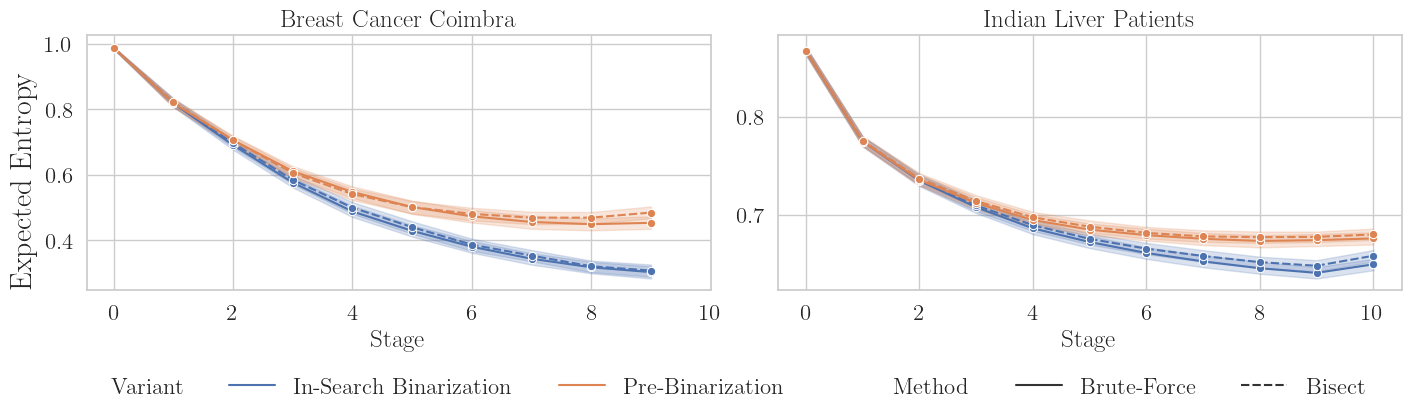

In [54]:
# 41945, 43979, 42900

label_mapping={"lookahead":"Lookahead",
               "method":"Method",
               "score_set": "Score Set",
               "calibration_method": "Calibration",
               "isotonic":"Isotonic Regression",
               "beta":"Beta Calibration",
               "psl_prebin":"Pre-Binarization",
               "psl":"In-Search Binarization",
               "stage":"Stage",
               "train_ent":"Expected Entropy",
               "clf_variant": "Variant",
               "bisect":"Bisect",
               "brute":"Brute-Force",
               "test_brier" : "Brier Score"
               }

# datasets = ["thorax", 42900, 41945]
datasets = [42900, 41945]
metric="train_ent"

fig,axes = plt.subplots(1,len(datasets), layout="constrained")
axes = axes.ravel()

for index, dataset in enumerate(datasets):
    ax=axes[index]
    df_ = df[
    (df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3)) 
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl","psl_prebin"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss.isnull())]
    # print(df_["method"].value_counts())
    sns.lineplot(data=df_, x="stage", y="train_ent", hue="clf_variant", style="method", marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Entropy")
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.18), frameon=False)
plt.savefig("binarization.pdf", bbox_extra_artists=(lgd,syl), bbox_inches="tight")

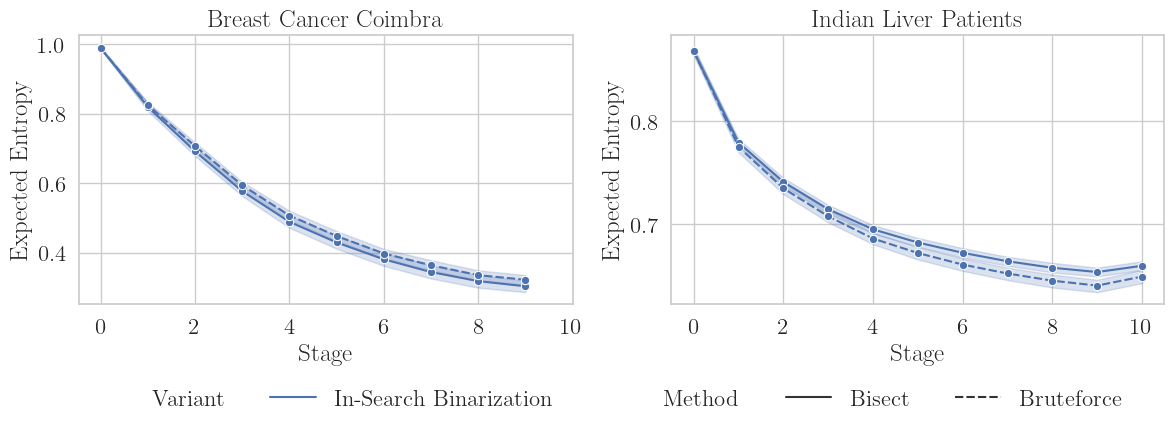

In [55]:
# 41945, 43979, 42900

label_mapping={"lookahead":"Lookahead",
               "method":"Method",
               "score_set": "Score Set",
               "calibration_method": "Calibration",
               "isotonic":"Isotonic Regression",
               "beta":"Beta Calibration",
               "psl_prebin":"Prebinarization",
               "psl":"In-Search Binarization",
               "stage":"Stage",
               "train_ent":"Expected Entropy",
               "clf_variant": "Variant",
               "bisect":"Bisect",
               "brute":"Bruteforce",
               "test_brier" : "Brier Score"
               }

# datasets = ["thorax", 42900, 41945]
datasets = [42900, 41945]
metric="train_ent"

fig,axes = plt.subplots(1,len(datasets))
axes = axes.ravel()

for index, dataset in enumerate(datasets):
    ax=axes[index]
    df_ = df[
    (df.dataset == datasets[index])
    # & (df.score_set==(-3, -2, -1, 1, 2, 3))
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    ]
    sns.lineplot(data=df_, x="stage", y="train_ent", hue="clf_variant", style="method", marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(label_mapping[metric])
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.25), frameon=False)
plt.savefig("binarization.pdf", bbox_extra_artists=(lgd,))

[(('calibration_method', 'isotonic'), 'psl')
 (('calibration_method', 'isotonic'), 'psl_logreg')
 (('calibration_method', 'beta'), 'psl')]
2650
[(('calibration_method', 'beta'), 'psl')
 (('calibration_method', 'isotonic'), 'psl')
 (('calibration_method', 'isotonic'), 'psl_logreg')]
2400
[(('calibration_method', 'isotonic'), 'psl')
 (('calibration_method', 'isotonic'), 'psl_logreg')
 (('calibration_method', 'beta'), 'psl')]
2650


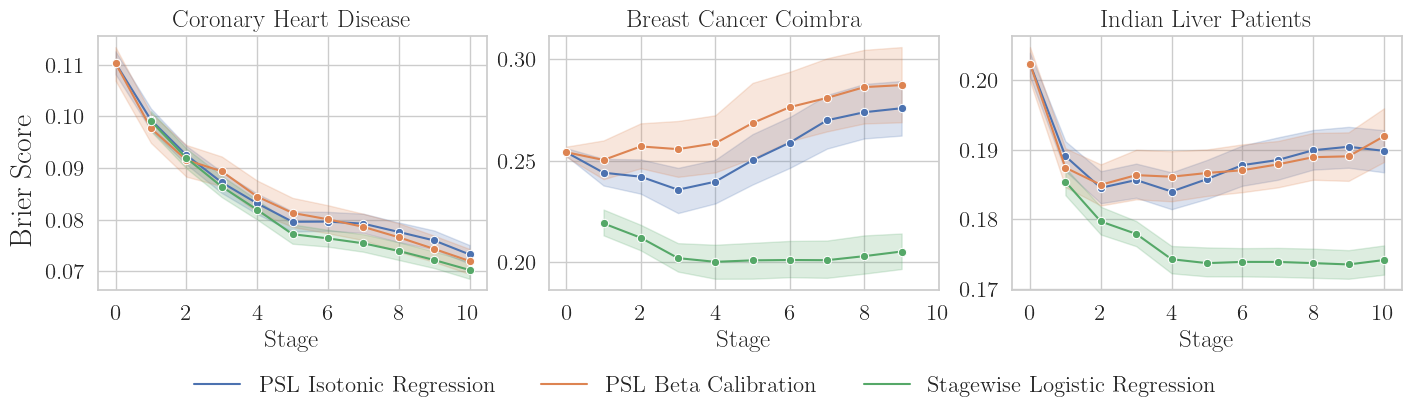

In [56]:
# 41945, 43979, 42900

label_mapping={"lookahead":"Lookahead",
               "method":"Method",
               "score_set": "Score Set",
               "calibration_method": "Calibration",
               "('calibration_method', 'isotonic')":"Isotonic Regression",
               "beta":"Beta Calibration",
               "psl_prebin":"Prebinarization",
               "psl":"In-Search Binarization",
               "stage":"Stage",
               "train_ent":"Expected Entropy",
               "clf_variant": "Variant",
               "bisect":"Bisect",
               "brute":"Bruteforce",
               "test_brier" : "Brier Score",
               "('calibration_method', 'beta')":"Beta Calibration",
               "(('calibration_method', 'beta'), 'psl')":"PSL Beta Calibration", 
               "(('calibration_method', 'isotonic'), 'psl')":"PSL Isotonic Regression",
                 "(('calibration_method', 'isotonic'), 'psl_logreg')": "Stagewise Logistic Regression"
               }

datasets = ["thorax", 42900, 41945]
metric="train_ent"

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3))
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (~df.stage.isnull())]
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    hue_order = [(('calibration_method', 'isotonic'), 'psl'), (('calibration_method', 'beta'), 'psl'), (('calibration_method', 'isotonic'), 'psl_logreg')]
    print(df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1).unique())
    sns.lineplot(data=df_, x="stage", y="test_brier", hue=df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1), hue_order=hue_order, marker="o", ax=ax)
    print(len(df_))
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Brier Score")
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("brier.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

stage_loss
soft_ranking_loss    550
expected_entropy     550
Name: count, dtype: int64
stage_loss
expected_entropy     500
soft_ranking_loss    500
Name: count, dtype: int64
stage_loss
soft_ranking_loss    550
expected_entropy     550
Name: count, dtype: int64


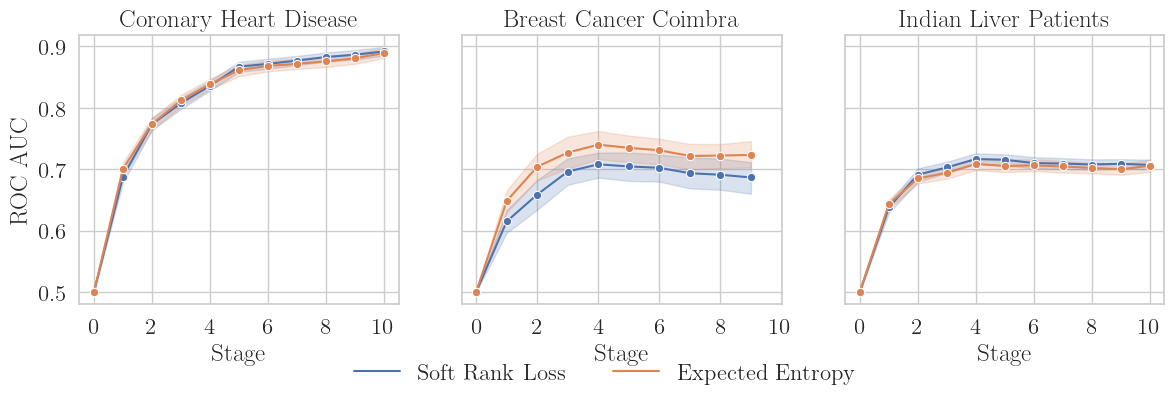

In [70]:
# 41945, 43979, 42900

label_mapping={"lookahead":"Lookahead",
               "method":"Method",
               "score_set": "Score Set",
               "calibration_method": "Calibration",
               "('calibration_method', 'isotonic')":"Isotonic Regression",
               "beta":"Beta Calibration",
               "psl_prebin":"Prebinarization",
               "psl":"In-Search Binarization",
               "stage":"Stage",
               "train_ent":"Expected Entropy",
               "clf_variant": "Variant",
               "bisect":"Bisect",
               "brute":"Bruteforce",
               "test_brier" : "Brier Score",
               "('calibration_method', 'beta')":"Beta Calibration",
               "test_roc" : "ROC AUC",
               "test_roc" : "ROC AUC",
               "soft_ranking_loss": "Soft Rank Loss",
               "expected_entropy":"Expected Entropy"
               }

datasets = ["thorax", 42900, 41945]
metric="train_ent"

fig,axes = plt.subplots(1,len(datasets), sharey=True, layout="constrained")
axes = axes.ravel()
hue_order = ["expected_entropy","soft_ranking_loss"]
for index, dataset in enumerate(datasets):
    ax=axes[index]
    df["stage_loss"] = df["stage_loss"].fillna("expected_entropy")
    df_ = df[
    (df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3)) 
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())]
    # & (df.stage_loss.isin([None, "soft_rank_loss"]))]
    print(df_.stage_loss.value_counts())
    sns.lineplot(data=df_, x="stage", y="test_roc", hue="stage_loss", marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(label_mapping["test_roc"])
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("roc_auc.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

In [58]:
# %%capture

# @delayed
# def create_figure(sample, metric):
#     sns.set(font_scale=1.5,rc={'text.usetex' : True})
#     sns.set_style("whitegrid")
#     plt.rc('font', **{'family': 'serif'})
#     plt.rcParams["figure.figsize"] = (18, 5)
#     fig, axes = plt.subplots()
#     sns.lineplot(data=df_, x="stage", y=f"{sample}_{metric}", hue=hue, style=variant, marker="o", ax=axes)
#     fig.savefig(f"../fig/{dataset} {variant} {sample}_{metric}.png", bbox_inches="tight")

# variants = [("clf_variant", "score_set"), ("clf_variant", "method"), ("clf_variant", "lookahead"), ("clf_variant", "stage_clf_params")]
# fixed = dict(score_set = (-3,-2,-1,1,2,3),
#              lookahead = 1,
#              stage_clf_params = ('calibration_method', 'isotonic'),
#              method = "bisect")

# for hue, variant in variants:
#     for dataset in ["thorax", 41945, 43979, 42900]:
#         df_ = df[df.dataset == dataset]

#         # Generate a mask for all rows that should be kept
#         mask = pd.Series([True] * len(df_), index=df_.index)
        
#         # Iterate through the items in fixed, but vectorize the checks where possible
#         for k, v in fixed.items():
#             if k != variant:
#                 # Update the mask: True if the value is v or None, False otherwise
#                 # Note: We use | for a bitwise OR to combine boolean masks
#                 mask &= (df_[k].isin([v]) | df_[k].isnull())
#         df_ = df_[mask]

#         Parallel(12)(
#             create_figure(sample, metric)
#             for sample, metric 
#             in product(["train", "test"], ["ent", "acc", "wloss", "bacc", "roc", "brier"]))

In [59]:
from util import DataLoader
datasets = [42900, 41945]

DATAFOLDER = "data"
X, y = DataLoader(DATAFOLDER).load(datasets[1])


In [60]:
np.count_nonzero(y)

416

In [61]:
len(y)

583

In [62]:
X

array([[65.  ,  0.  ,  0.7 , ...,  6.8 ,  3.3 ,  0.9 ],
       [62.  ,  1.  , 10.9 , ...,  7.5 ,  3.2 ,  0.74],
       [62.  ,  1.  ,  7.3 , ...,  7.  ,  3.3 ,  0.89],
       ...,
       [52.  ,  1.  ,  0.8 , ...,  6.4 ,  3.2 ,  1.  ],
       [31.  ,  1.  ,  1.3 , ...,  6.8 ,  3.4 ,  1.  ],
       [38.  ,  1.  ,  1.  , ...,  7.3 ,  4.4 ,  1.5 ]])